# Week 7 -- Cluster Analysis

This week, we'll continue to analyze the survey results by department.  In particular, we'll look at the five dimensions covered by the survey to understand if there are natural groupings within the employee population.  The metrics reflected in the survey are:

- ```engagement```
- ```leadership```
- ```enablement```
- ```alignment```
- ```development```



In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='plotly_mimetype+notebook_connected'
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [2]:
# Read and prep survey data
df = pd.read_csv('roster_with_score_2.csv')
df.drop(columns = [c for c in df.columns if c.startswith('Unnamed')], inplace=True)

# Part 1: Cluster Analysis

# Q1: Correlation Coefficient


(a) Compute the Pearson correlation coefficient between the five survey measurements outlined above and the **overall** as a $6 \times 6$ matrix and present it as a heatmap.

(b) What survey measurements seem most correlated to the **overall** result?

(c) What survey measurements seem least correlated to the **overall** result?

In [3]:
# Key survey dimensions
dimensions = [
    'engagement',
    'leadership',
    'enablement',
    'alignment',
    'development',
    'overall'
]

# Subset of data for relevant dimensions
sub = df[dimensions]

# Compute correlation of survey dimensions
surv_corr = sub.corr()
surv_corr

,engagement,leadership,enablement,alignment,development,overall
engagement,1.000000,0.682240,0.643975,0.233225,0.097308,0.762661
leadership,0.682240,1.000000,0.625720,0.258075,0.068394,0.806821
enablement,0.643975,0.625720,1.000000,0.208898,0.156849,0.806670
alignment,0.233225,0.258075,0.208898,1.000000,0.277685,0.543687
development,0.097308,0.068394,0.156849,0.277685,1.000000,0.459045
overall,0.762661,0.806821,0.806670,0.543687,0.459045,1.000000


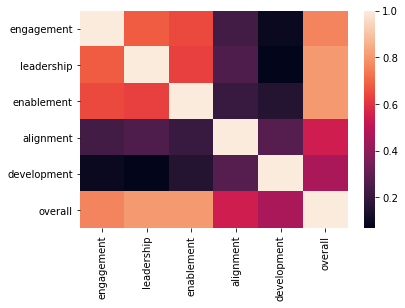

In [4]:
# Correlation heatmap
sns.heatmap(surv_corr);

### Correlation Analysis
The factors that are `most related` to overall results are `leadership and enablement`.

The factors that are `least related` to overall results are `alignment adn development`. 

# Q2: K-Means Clustering

Let's run a K Means cluster analysis for all users the five measurements covered by the survey.

(a) Run a K Means cluster analysis for two clusters
 - plot a scatter matrix of the five survey measurements color coded by cluster

(b) Run a K Means cluster analysis for three clusters
 - plot a scatter matrix of the five survey measurements color coded by cluster

(c) Use the Elbow method to identify the optimum number of clusters
 - plot the elbow method with Inertia
 - plot the elbow method with Calinski-Harabasz score

(d) What number of clusters would you use and why? 

(e) Let's try to understand **overall** survey results by department.  Let's use a box plot with the x-axis being "department" and the y-axis showing **overall** responses.  You can color code groups of cluster membership.

(f) Which departments show the highest percentage of members of the most satisfied clusters?  Produce a Pareto plot.

(g) Which departments show the highest percentage of members of the least satisfied clusters? Produce a Pareto plot.

In [5]:
# 2-cluster Kmeans
model = KMeans(n_clusters=2, random_state=42).fit(sub)
km2_df = sub.copy()
km2_df['cluster'] = model.labels_
px.scatter_matrix(km2_df, color='cluster')

In [6]:
# 3-cluster Kmeans
model = KMeans(n_clusters=3, random_state=42).fit(sub)
km3_df = sub.copy()
km3_df['cluster'] = model.labels_
px.scatter_matrix(km3_df, color='cluster')

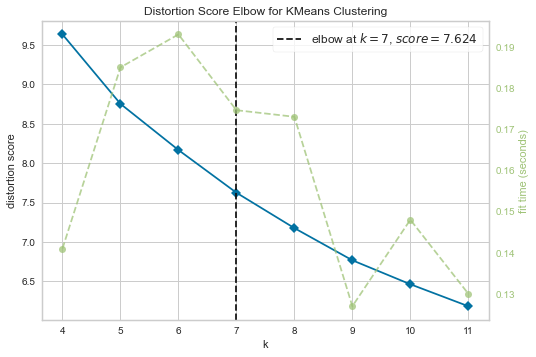

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
# Intertia elbow method
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))
visualizer.fit(sub)
visualizer.show()

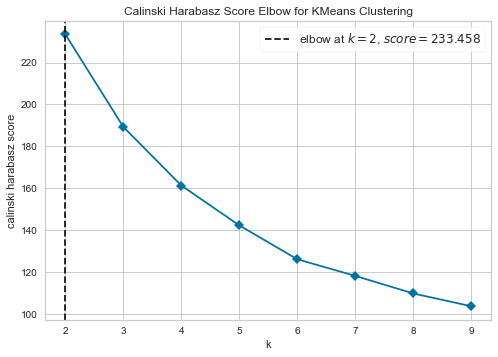

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [8]:
# Calisnki-Harabasz Elbow method
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,10), metric='calinski_harabasz', timings=False
)
visualizer.fit(sub)
visualizer.show()

### Elbow Analysis
The smooth nature of the curve observed in the elbow method visualizations indicates that the data is not very clustered, and means that the optimal `K` value isn't entirely clear.

The Calinski-Harabasz method is especially inaccurate, as it just selects the first possible `K` as the optimal cluster count. Therefore, I'd recommend we use the distorition (inertia) method which recommends 7 clusters (`K=7`).

In [9]:
# Overall results analysis
model = KMeans(n_clusters=7, random_state=42).fit(sub)
km7_df = df.copy()
km7_df['cluster'] = model.labels_
px.box(km7_df, x='department', y='overall', color='cluster')

In [10]:
px.scatter(km7_df, x='department', y='overall', color='cluster')

### Department-Cluster Analsyis
The box plot does not show the percentage of observations within a department that fall in each cluster, but rather the statistical makeup of the observations within that department and cluster. A scatterplot gives us a better visual picture of the volume of observations within the separate clusters, but still is hard to evaluate which departments specifically have the highest percentage of their employees is the most satistifed clusters. For example, 3/4 Loan Operations employees are in the most satisfied clusters, which is hard to tell without looking closely. Additionally, Front End appears to have a large proportion of employees in satisfied clusters. Some of the least satisfied departments appear to be Channel Marketing and Midwest Lending.

In [11]:
def avg_chart(df, department):
    df = df[df['department'] == department]
    ax = px.scatter(df, x='cluster', y='overall', title='Clusters in '+department)
    return ax

In [12]:
for dep in ['Loan Operations','Front End','Channel Marketing','Midwest Lending']:
    ax = avg_chart(km7_df, dep)
    ax.show()

# Q3: Hierarchical Clustering

1. Run a hierarchical cluster analysis with three clusters for all users covered by the five measures in the survey. Be sure to use the Ward linkage.
2. Visualize the clustering hierarchy using scatter matrices. 
3. Using the output with 3 clusters, complete the following:
    - Produce a box plot to show the distribution of overall responses by department and color-code the responses by cluster membership.
    - Identify the departments that show the highest percentage of members of the most satisfied clusters. Then identify those departments with the highest percentage of members of the least satisfied clusters. 

In [13]:
# Ward method hierarchical clustering
link='ward'
model = AgglomerativeClustering(n_clusters=3, linkage=link).fit(sub)
fig = px.scatter_matrix(sub, color=model.labels_, color_continuous_scale=['red','green'],title=link+' Method')
fig.show()

In [14]:
ac_df = df.copy()
ac_df['cluster'] = model.labels_
px.box(ac_df, x='department', y='overall', color='cluster')

### Hierarchical Cluster Analysis
As discussed before, the box plot does not inherently show the percentage distribution of departments amont clusters. The presence of a complete plot shows that employees exist in the cluster and department, but the proportion is unknown based on this plot. Assuming that larger boxes mean a larger proportion of the department exists in that cluster (not necessarily true but has some basis), most satisfied departments include Underwriting and Loan Operations while least satisfied include Southwest Lending and FHA Loans.

# Q4: Compare Results

(a) What are the most satisfied departments based on the two approaches?

(b) What are the least satisfied departments based on the two approaches?

(c) How do the dissatisfaction results compare to the statistical analysis from week 4?

The most satisfied departments appear to be operational departments (Loan Operations, Underwriting) and Technology (Front End, Back End).

The least satistifed departments appear to be the lending functions such as Southwest Lending and FHA Loans, as well as channel marketing.

This is relatively consistent with the results identified in the statistical analysis for module 4, as multiple technology departments (Full Stack, Front End, Algorithm Development) were found to overperform while lending functions (Midwest lending, southwest lending, FHA loans) underperformed.

# Part 2 : Recommendation Mail

Write an email to your team lead outlining your recommendations for LoanTronic, based on all of your data analysis throughout the project. 

   - Identify those departments which should be placed on the watch list for LoanTronic to closely monitor employee satisfaction. Where are the pockets of dissatisfaction? Be sure to support your recommendation with data analysis
   
   
   - Describe key factors that may be impacting employee dissatisfaction, based on your analysis.
   
   
   - Describe the biases that can be gleaned from the analyses performed throughout this project. What should LoanTronic be aware of, and how should they use these biases going forward?
   
   
   - Create data visualizations to support your recommendations, and clearly communicate the data analysis to your team lead.

In [16]:
!jupyter nbconvert --to html --template full *.ipynb

[NbConvertApp] Converting notebook LoanTronic_Clustering.ipynb to html
[NbConvertApp] Writing 725196 bytes to LoanTronic_Clustering.html
